<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Quantização-de-cores" data-toc-modified-id="Quantização-de-cores-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Quantização de cores</a></span><ul class="toc-item"><li><span><a href="#Imagem-original-e-cores" data-toc-modified-id="Imagem-original-e-cores-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Imagem original e cores</a></span></li><li><span><a href="#Quantização-aleatória" data-toc-modified-id="Quantização-aleatória-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Quantização aleatória</a></span></li><li><span><a href="#Experimentando:-Quantização-pelas-cores-mais-frequentes" data-toc-modified-id="Experimentando:-Quantização-pelas-cores-mais-frequentes-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Experimentando: Quantização pelas cores mais frequentes</a></span></li><li><span><a href="#Experimentando:-Quantização-com-limiar-constante" data-toc-modified-id="Experimentando:-Quantização-com-limiar-constante-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Experimentando: Quantização com limiar constante</a></span></li><li><span><a href="#Quantização-com-K-Means" data-toc-modified-id="Quantização-com-K-Means-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Quantização com K-Means</a></span></li></ul></li></ul></div>

# Computação gráfica: Trabalho A1

Aluna: Fernanda Scovino

Referências:

- [Color quantization using K-Means](https://lmcaraig.com/color-quantization-using-k-means) (adaptação do código)
- [Imagem - Prof. Thales Vieira, Instituto de Matemática, UFA](http://www.ic.ufal.br/professor/thales/icg/Aula3.pdf)

----

## Quantização de cores

Procedimento utilizado para discretização do espaço de cores (podendo esse ser originalmente finito ou infinito). 

### Imagem original e cores

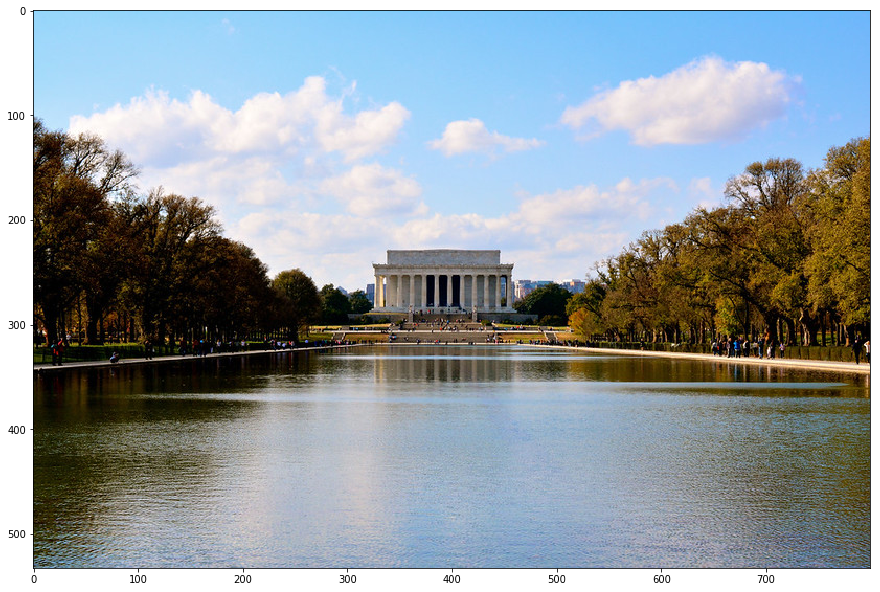

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15,15))
# Leitura da imagem
img = mpimg.imread('../images/washington.jpg')
# Plot da imagem no suporte
imgplot = plt.imshow(img)
plt.show()

* Qual o tamanho da imagem?

In [3]:
img.shape # A imagem possui 533 x 800 pixels (i.e. unidades de cor)

(533, 800, 3)

* Quantas cores únicas temos na imagem?

In [6]:
import numpy as np

def count_colors(img, lenght=True):
    """
    Conta o número de cores únicas (RGB) na imagem.
    """
    
    if len(img.shape) > 2:
        
        width, height, depth = img.shape

        # Redimensionando o suporte da imagem de R^2 para R
        img = np.reshape(img, (width * height, depth))
    
    # Selecionando as cores únicas (set)
    colors = set([tuple(i) for i in img])
        
    if lenght:
        print('Total de cores na imagem:', len(colors))
    else:
        colors = np.array(list(colors))
        return colors

In [7]:
count_colors(img)

Total de cores na imagem: 102927


### Quantização aleatória

In [10]:
from sklearn.metrics import pairwise_distances_argmin
from sklearn.utils import shuffle

def quantize_shuffle(img, n_colors, metric='euclidean'):
    
    width, height, depth = img.shape
    
    # Redimensionando o suporte da imagem de R^2 para R
    flatten_img = np.reshape(img, (width * height, depth))

    # Selecionando um a paleta aleatória
    palette = shuffle(flatten_img)[:n_colors]
    
    # Busca pela cor mais próxima na paleta
    labels = pairwise_distances_argmin(flatten_img, palette, metric=metric)

    # Redistribui as cores no suporte
    quantized_raster = np.reshape(palette[labels], (width, height, palette.shape[1]))

    return quantized_raster

In [11]:
%%time
img_compress = quantize_shuffle(img, 20, metric='euclidean')

CPU times: user 262 ms, sys: 59.1 ms, total: 321 ms
Wall time: 219 ms


* Agora temos uma imagem comprimida com 20 cores

In [12]:
count_colors(img_compress)

Total de cores na imagem: 20


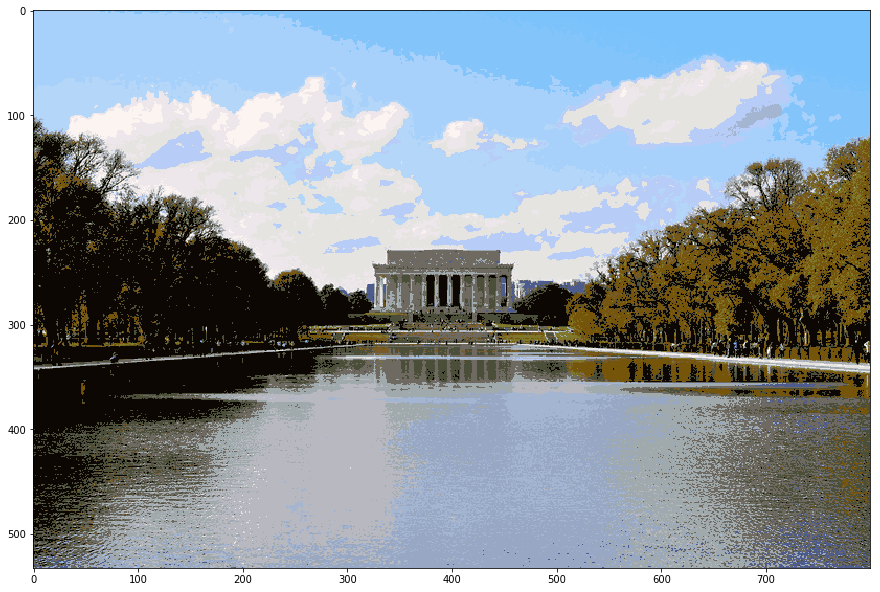

In [13]:
plt.figure(figsize=(15,15))
imgplot = plt.imshow(img_compress)
plt.show()

In [18]:
from PIL import Image

im = Image.fromarray(img_compress)
im.save("../images/qtz_aleatoria.jpg")

### Experimentando: Quantização pelas cores mais frequentes

In [19]:
width, height, depth = img.shape
reshaped_raster = np.reshape(img, (width * height, depth))

In [20]:
from collections import Counter

count_freq = Counter([tuple(i) for i in reshaped_raster])
count_freq.most_common(20)

[((161, 215, 251), 609),
 ((0, 0, 0), 575),
 ((1, 0, 0), 571),
 ((163, 216, 250), 537),
 ((151, 210, 250), 515),
 ((166, 216, 251), 513),
 ((160, 214, 250), 512),
 ((4, 0, 0), 479),
 ((158, 214, 251), 471),
 ((146, 207, 251), 468),
 ((159, 213, 251), 465),
 ((0, 1, 0), 458),
 ((3, 0, 0), 453),
 ((156, 214, 251), 444),
 ((154, 212, 250), 439),
 ((162, 214, 251), 433),
 ((148, 210, 251), 422),
 ((135, 201, 251), 418),
 ((159, 215, 250), 414),
 ((154, 214, 250), 413)]

In [21]:
def quantize_freq(img, n_colors, metric='euclidean'):
    
    width, height, depth = img.shape
    
    # Redimensionando o suporte da imagem de R^2 para R
    flatten_img = np.reshape(img, (width * height, depth))

    # Selecionando uma paleta com as n cores mais frequentes
    count_freq = Counter([tuple(i) for i in reshaped_raster])
    palette = np.array([i[0] for i in count_freq.most_common(n_colors)])
    
    # Busca pela cor mais próxima na paleta
    labels = pairwise_distances_argmin(reshaped_raster, palette, metric)

    # Redistribui as cores no suporte
    quantized_raster = np.reshape(palette[labels], (width, height, len(palette[0])))

    return quantized_raster

In [22]:
%%time
img_freq = quantize_freq(img, 64)

CPU times: user 1.41 s, sys: 175 ms, total: 1.58 s
Wall time: 1.48 s


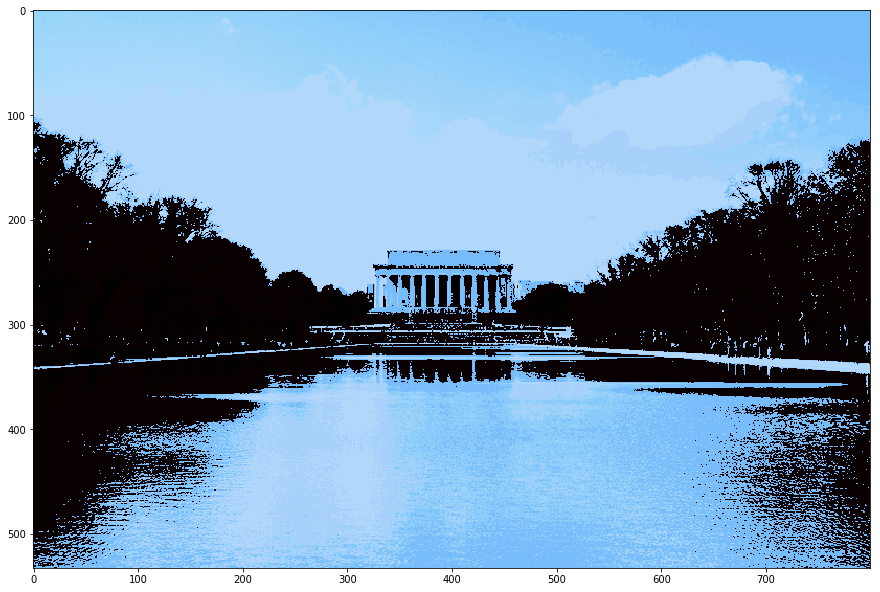

In [23]:
plt.figure(figsize=(15,15))
imgplot = plt.imshow(img_freq)
plt.show()

In [25]:
from PIL import Image

im = Image.fromarray(img_freq)
im.save("../images/qtz_frequente.jpg")

### Experimentando: Quantização com limiar constante

In [35]:
def quantize_fixed_lim(raster, limit, metric='euclidean'):
    
    width, height, depth = img.shape

    # Redimensionando o suporte da imagem de R^2 para R
    flatten_img = np.reshape(img, (width * height, depth))

    palette = list(filter(lambda cel: np.all(cel > limit), flatten_img))
    palette = count_colors(np.array(palette), lenght=False)
    print('Número de cores na paleta:', len(palette))
    
    # Busca pela cor mais próxima na paleta
    labels = pairwise_distances_argmin(reshaped_raster, palette, metric)

    # Redistribui as cores no suporte
    quantized_raster = np.reshape(palette[labels], (width, height, len(palette[0])))
        
    return quantized_raster

* Testando para as cores mais azuis (B > 250):

In [42]:
%%time
threshold = np.array([0,0,250])
img_limit = quantize_fixed_lim(img, threshold)

Número de cores na paleta: 2458
CPU times: user 15.6 s, sys: 4.32 s, total: 20 s
Wall time: 19.7 s


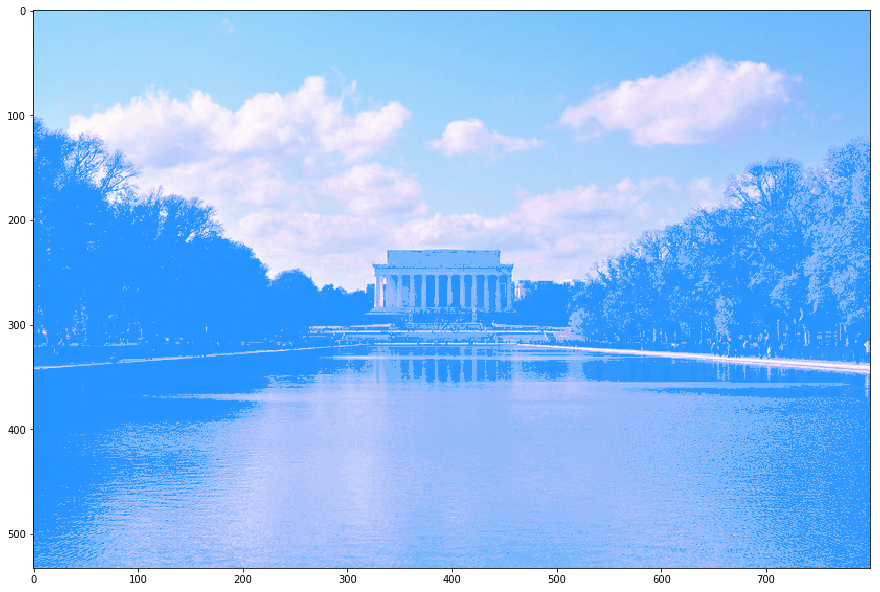

In [43]:
plt.figure(figsize=(15,15))
imgplot = plt.imshow(img_limit)
plt.show()

In [44]:
from PIL import Image

im = Image.fromarray(img_limit)
im.save("../images/qtz_azul.jpg")

* Agora o mesmo para o mais verde (G > 250):

In [45]:
%%time
threshold = np.array([0,250,0])
img_limit = quantize_fixed_lim(img, threshold)

Número de cores na paleta: 155
CPU times: user 3.95 s, sys: 321 ms, total: 4.27 s
Wall time: 4.71 s


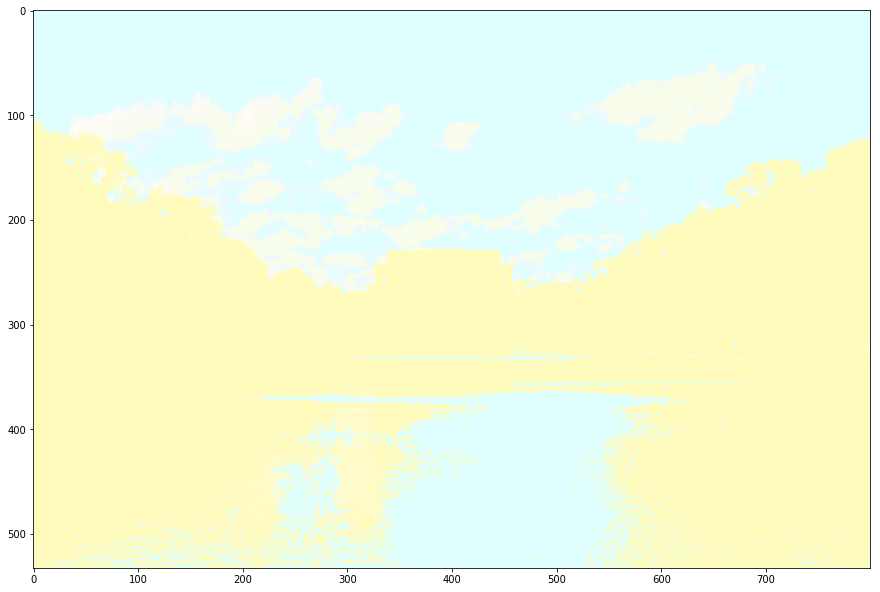

In [46]:
plt.figure(figsize=(15,15))
imgplot = plt.imshow(img_limit)
plt.show()

In [47]:
from PIL import Image

im = Image.fromarray(img_limit)
im.save("../images/qtz_verde.jpg")

* E para o vermelho (R > 250):

In [48]:
%%time
threshold = np.array([250,0,0])
img_limit = quantize_fixed_lim(img, threshold)

Número de cores na paleta: 760
CPU times: user 7.53 s, sys: 2.52 s, total: 10.1 s
Wall time: 12.2 s


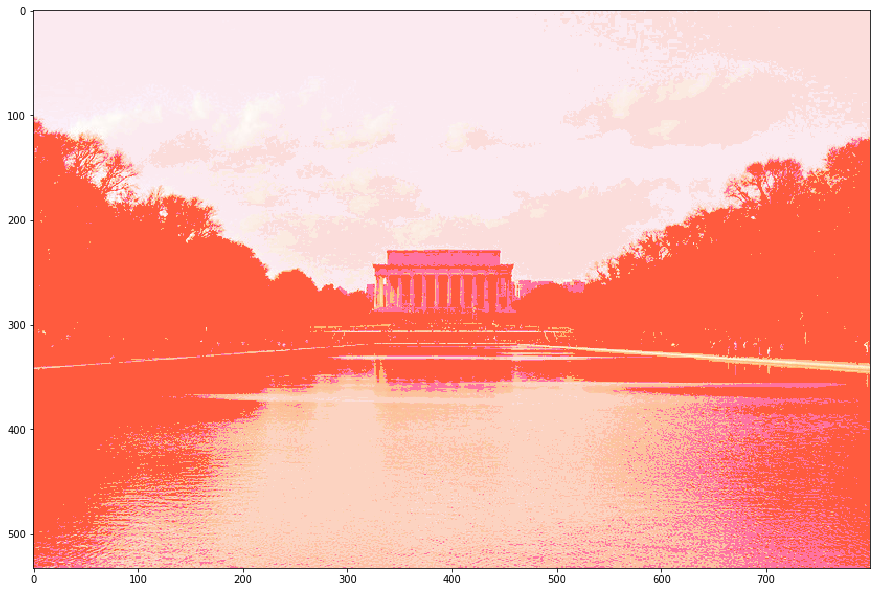

In [49]:
plt.figure(figsize=(15,15))
imgplot = plt.imshow(img_limit)
plt.show()

In [50]:
from PIL import Image

im = Image.fromarray(img_limit)
im.save("../images/qtz_vermelho.jpg")

### Quantização com K-Means

In [53]:
import numpy as np
from sklearn import cluster

def quantize_kmeans(img, n_colors):
    
    width, height, depth = img.shape
    
    # Redimensionando o suporte da imagem de R^2 para R
    flatten_img = np.reshape(img, (width * height, depth))

    # Busca pelas cores para formar a paleta (cria os grupos)
    model = cluster.KMeans(n_clusters=n_colors)
    
    # Seleciona os grupos de cada ponto
    labels = model.fit_predict(flatten_img)
    
    # Seleciona as cores dos centróides de ccada grupo
    palette = model.cluster_centers_
    
    # Redistribui as cores no suporte de acordo com seu grupo
    quantized_raster = np.reshape(palette[labels], (width, height, palette.shape[1]))

    return quantized_raster

In [54]:
%%time
img_kmeans = quantize_kmeans(img, 20)

CPU times: user 52.5 s, sys: 7.86 s, total: 1min
Wall time: 1min 13s


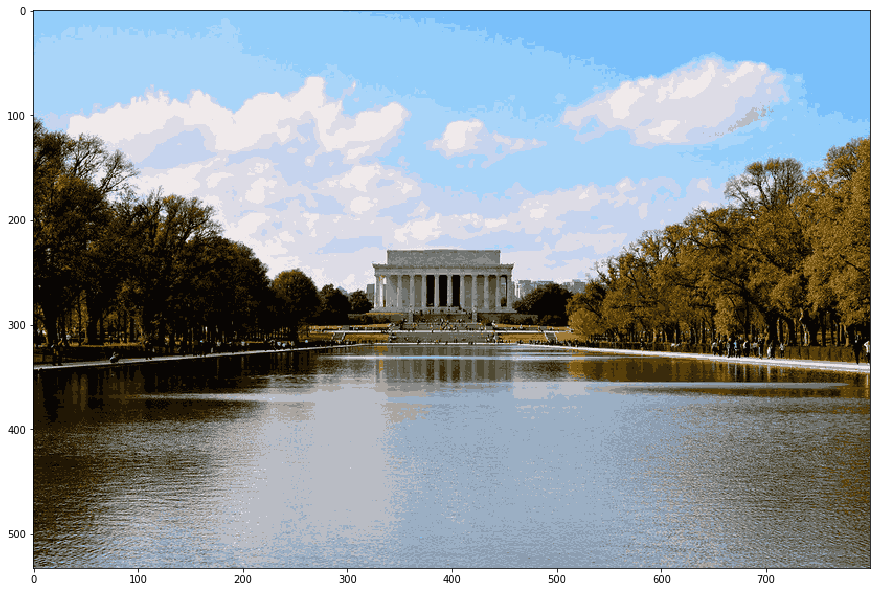

In [55]:
plt.figure(figsize=(15,15))
imgplot = plt.imshow(img_kmeans.astype(int))
plt.show()

In [60]:
img_kmeans = img_kmeans.astype(int)

In [63]:
from PIL import Image

im = Image.fromarray(img_kmeans.astype('uint8'))
im.save("../images/qtz_kmeans.jpg")